In [25]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
from nltk.corpus import stopwords
import pickle 

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD

In [2]:
aita_2 = pd.read_csv('data/aita_save2.csv')
aita_2.dropna(subset=['body_clean', 'title_clean'], inplace=True)

In [3]:
aita = aita_2[['body_polarity','body_subjectivity','title_polarity','title_subjectivity','is_asshole']]
aita['title_body_combo'] =  aita_2['title_clean'] + aita_2['body_clean']

<ipython-input-3-fdbad7dd0d8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aita['title_body_combo'] =  aita_2['title_clean'] + aita_2['body_clean']


In [4]:
aita

,body_polarity,body_subjectivity,title_polarity,title_subjectivity,is_asshole,title_body_combo
0,-0.156818,0.656818,0.0,0.0,1,I write an explanation in til and come off a...
1,0.034848,0.449242,0.0,0.0,1,throw my parent donut awaymy parent be diabe...
2,0.000000,0.000000,0.0,0.0,0,I tell a goth girl she look like a clownI be four
3,0.000000,0.000000,0.0,0.0,1,argument I have with another redditor in rhi...
4,0.040104,0.369792,0.0,0.0,1,have a disagreement about le miserable with ...
...,...,...,...,...,...,...
97536,0.016111,0.385278,0.0,0.0,0,for tell my sister she be be a spoiled bratm...
97537,0.068461,0.474614,0.0,0.0,0,for tell my husband to f off after he relent...
97538,-0.076333,0.493467,0.1,0.3,0,for attempt to keep my student out of adult ...
97539,0.067130,0.426132,0.0,0.0,0,if I leave my brother fate up to the statea ...


In [5]:
X = aita.drop('is_asshole', axis=1)
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.30)

In [6]:
X_train.shape, X_test.shape

((68218, 5), (29237, 5))

In [7]:
stop = set(stopwords.words('english'))
vec = CountVectorizer(stop_words=stop, min_df=5, max_df=0.8) #ngram_range=(1,2)
cv = vec.fit(X_train['title_body_combo'])
cv_train = vec.transform(X_train['title_body_combo'])
cv_test = vec.transform(X_test['title_body_combo'])

### Save fitted CountVectorizer to use later

In [10]:
pickle.dump(cv, open('cv_fit_train.sav', 'wb'))

In [11]:
dtm_train = pd.DataFrame(cv_train.toarray(), columns=vec.get_feature_names())
train_word_count = dtm_train.sum(axis=0)
train_word_count.sort_values(ascending=False)[:10]

get       161674
go        140343
say       139851
tell      119923
would     117233
want      113142
like       98360
friend     93786
time       86635
know       76547
dtype: int64

In [12]:
dtm_test = pd.DataFrame(cv_test.toarray(), columns=vec.get_feature_names())
test_word_count = dtm_test.sum(axis=0)
test_word_count.sort_values(ascending=False)[:10]

get       69602
go        59737
say       59548
tell      51039
would     49984
want      47829
like      42409
friend    39713
time      36841
know      32687
dtype: int64

In [13]:
dtm_train.shape, dtm_test.shape

((68218, 21183), (29237, 21183))

### Save / Load Document Term Matrix to / from csv

In [14]:
# dtm_train.to_csv('data/dtm_train.csv', index=False)
# dtm_test.to_csv('data/dtm_test.csv', index=False)

dtm_train = pd.read_csv('data/dtm_train.csv')
dtm_test = pd.read_csv('data/dtm_test.csv')

In [15]:
dtm_train

,aa,aaa,aaaand,aaron,ab,aback,abandon,abandonment,abbey,abbie,...,zipper,zit,zodiac,zoe,zombie,zone,zoo,zoom,zs,zumba
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68213,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68214,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68215,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
68216,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## PCA

In [12]:
pca = IncrementalPCA(n_components=1000, batch_size=1000)
pca.fit(dtm_train)
print(pca.explained_variance_ratio_.sum())

/Users/czeng/miniforge3/lib/python3.9/site-packages/sklearn/decomposition/_incremental_pca.py:316: RuntimeWarning: Mean of empty slice.
  explained_variance[self.n_components_:].mean()
/Users/czeng/miniforge3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Save / Load fitted PCA Model

In [20]:
# pickle.dump(pca, open('pca.sav', 'wb'))

pca = pickle.load(open('pca.sav', 'rb'))
pca

IncrementalPCA(batch_size=700, n_components=700)

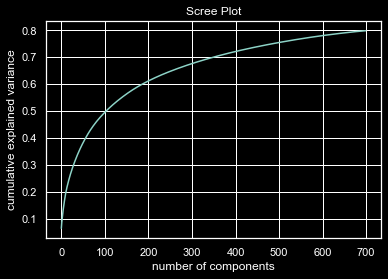

In [27]:
# sns.set(style='whitegrid')

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.title('Scree Plot')
# plt.axvline(linewidth=4, color='r', linestyle = '--', x=10, ymin=0, ymax=1)
evr = pca.explained_variance_ratio_
cvr = np.cumsum(pca.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
# display(pca_df.head(10))

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.063661,0.063661
1,0.085633,0.021972
2,0.101203,0.015570
3,0.115812,0.014609
4,0.129328,0.013516
...,...,...
695,0.797364,0.000140
696,0.797500,0.000137
697,0.797635,0.000135
698,0.797768,0.000132


In [30]:
# pca.transform(dtm_train)

In [29]:
# X_train_post_dtm = pd.concat([X_train[['title_polarity','title_subjectivity', 'body_polarity','body_subjectivity']].reset_index(drop=True),dtm_train], axis=1)
# X_test_post_dtm = pd.concat([X_train[['title_polarity','title_subjectivity', 'body_polarity','body_subjectivity']].reset_index(drop=True),dtm_test], axis=1)

In [ ]:
# rfc = RandomForestClassifier()
# rfc.fit(X_train_post_dtm, y_train)